# Earthquake Data Analysis

The project consists of analyzing a dataset (called also "catalog") of earthquakes collected in about 20 years of recording in South California.

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* __Waiting time (t)__: time interval between an event and the next one in the sequence.
* __Distance (r)__: Euclidean 3D distance between events (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake).

## Data

The catalog `SouthCalifornia-1982-2011.dat` is a data file with the following content:

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (in meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

By joining each event to that with the index of the second column (if not -1), a set of causal trees would emerge.


## Assignments

1. Visualize the process in space and/or time with a suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or an appropriate linear combination of coordinates) as a function of time.
2. Compute the distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$. If deemed appropriate, choose a function and fit it to the data.
3. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude $m$ or above. Make a clever choice for the bin sizes, and try several values of $m$. Fit the data with an appropriate function, if possible.
4. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. In this case, if the following event is farther than $R$, skip the $t$ and go to the next pair.
5. Comment whether there is a scaling law from the analysis of the previous points. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
import warnings

# Ignore RuntimeWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Load the data
data_path = 'SouthCalifornia-1982-2011.dat'
columns = ['event_index', 'trigger_index', 'time', 'magnitude', 'x', 'y', 'z']
data = pd.read_csv(data_path, delim_whitespace=True, names=columns)

# Convert time from seconds to years for easier interpretation
data['time_years'] = data['time'] / (60 * 60 * 24 * 365.25)

In [7]:
data.head(10)

,event_index,trigger_index,time,magnitude,x,y,z,time_years
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602,0.000000
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373,0.001157
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232,0.001188
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479,0.001520
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546,0.001910
5,5,0,100612.80864,2.04,-2545592,-4588519,3597315,0.003188
6,6,0,106358.95296,2.27,-2361034,-4748837,3502194,0.003370
7,7,0,127529.37216,2.64,-2484433,-4558759,3679010,0.004041
8,8,0,130364.57088,2.62,-2429713,-4582352,3681247,0.004131
9,9,0,134132.56128,2.48,-2526232,-4571575,3618942,0.004250


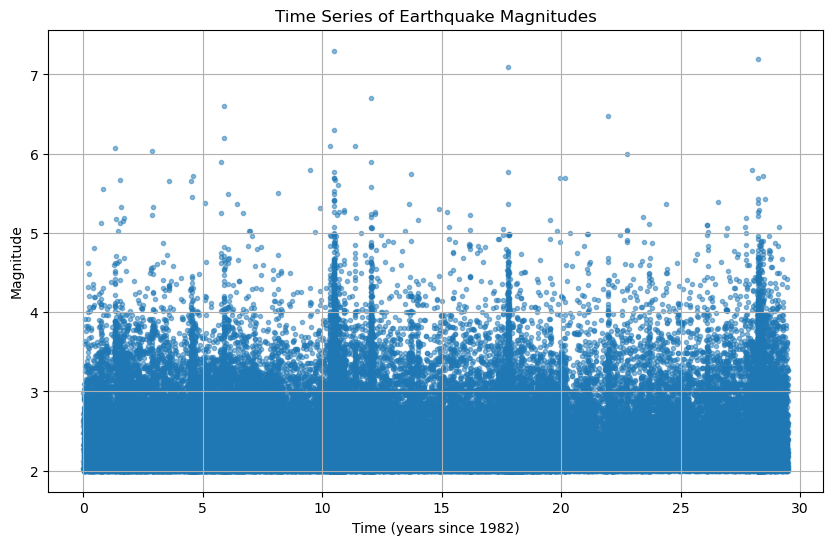

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(data['time_years'], data['magnitude'], alpha=0.5, marker='.')
plt.title('Time Series of Earthquake Magnitudes')
plt.xlabel('Time (years since 1982)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

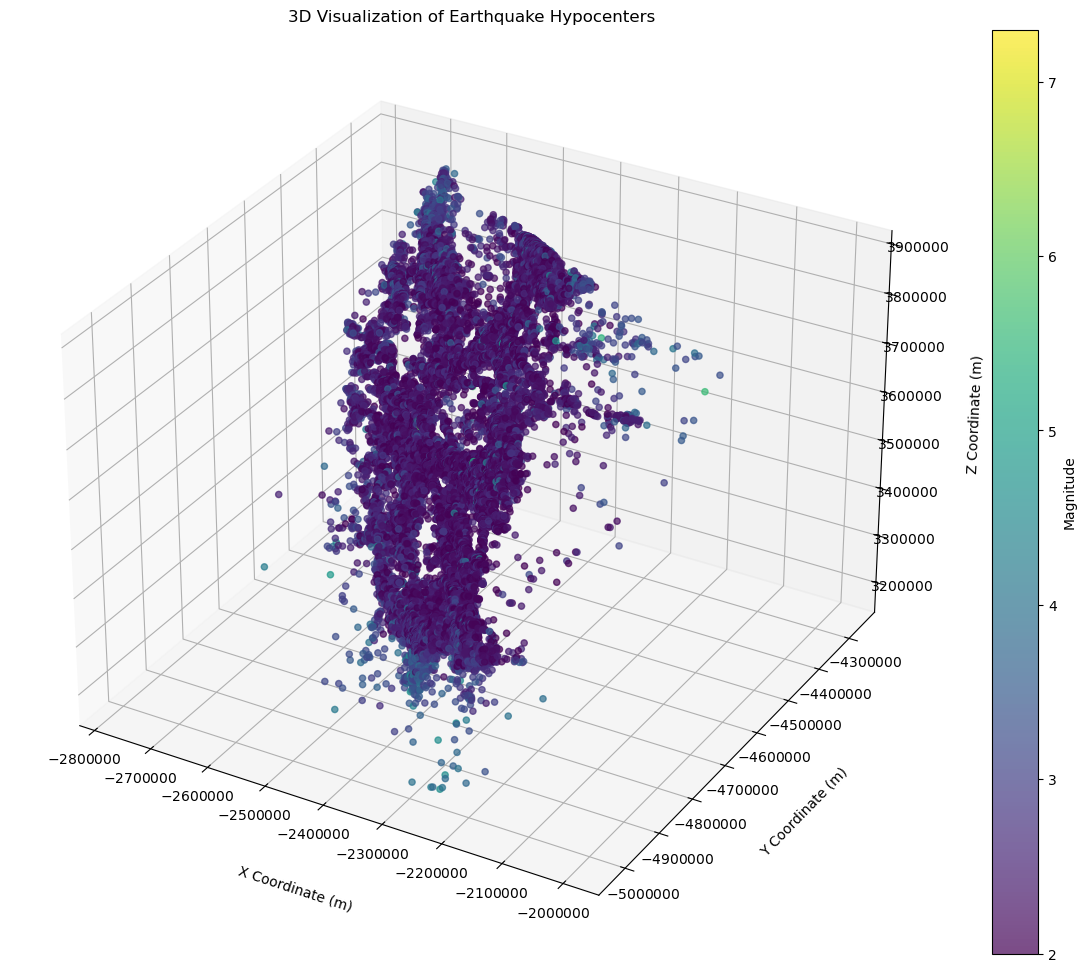

In [9]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of hypocenters
sc = ax.scatter(data['x'], data['y'], data['z'], c=data['magnitude'], cmap='viridis', marker='o', alpha=0.7)

ax.set_title('3D Visualization of Earthquake Hypocenters')
ax.set_xlabel('X Coordinate (m)', labelpad=20)
ax.set_ylabel('Y Coordinate (m)', labelpad=20)
ax.set_zlabel('Z Coordinate (m)', labelpad=20)

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-10, 10))

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.zaxis.set_major_formatter(formatter)

# Color bar indicating magnitude
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Magnitude')

plt.show()

In [10]:
def compute_waiting_times(data, magnitude_threshold):
    # Filter data for the given magnitude threshold
    filtered_data = data[data['magnitude'] >= magnitude_threshold]
    filtered_data = filtered_data.sort_values(by='time')

    # Compute waiting times (time differences between consecutive earthquakes)
    waiting_times = np.diff(filtered_data['time'])
    return waiting_times

# Magnitudes to analyze
magnitude_thresholds = [2, 3, 4, 5]
waiting_times_by_magnitude = {}

for m in magnitude_thresholds:
    waiting_times_by_magnitude[m] = compute_waiting_times(data, m)


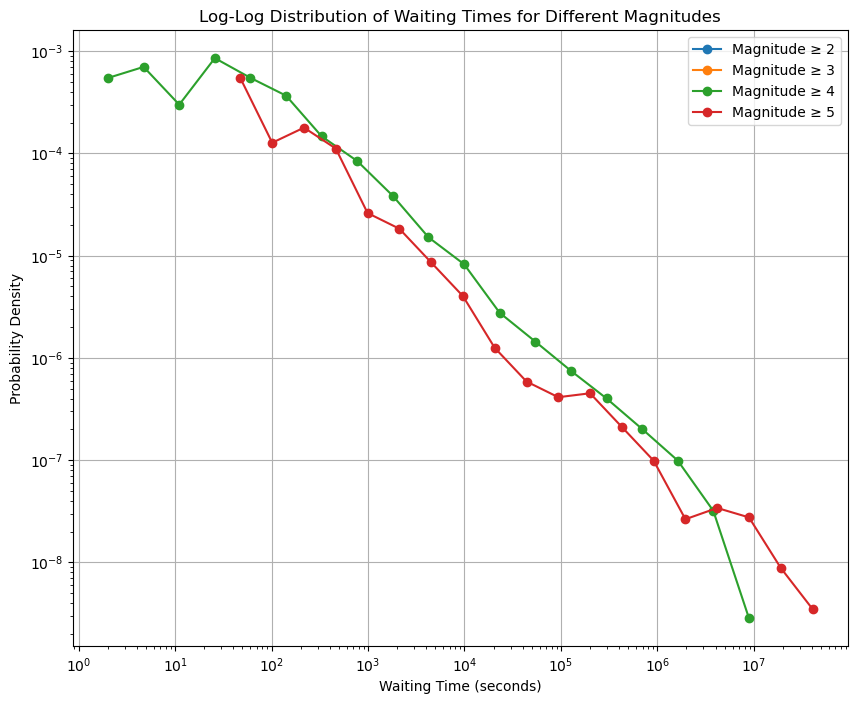

In [11]:
plt.figure(figsize=(10, 8))

for m, waiting_times in waiting_times_by_magnitude.items():
    bins = np.logspace(np.log10(min(waiting_times)), np.log10(max(waiting_times)), num=20)
    hist, bin_edges = np.histogram(waiting_times, bins=bins, density=True)
    plt.loglog((bin_edges[:-1] + bin_edges[1:]) / 2, hist, marker='o', linestyle='-', label=f'Magnitude ≥ {m}')

plt.title('Log-Log Distribution of Waiting Times for Different Magnitudes')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def compute_waiting_distance(data, magnitude_threshold):
    # Filter data for the given magnitude threshold
    filtered_data = data[data['magnitude'] >= magnitude_threshold].copy()
    filtered_data.sort_values(by='time', inplace=True)

    # Calculate distances
    x1, y1, z1 = filtered_data['x'], filtered_data['y'], filtered_data['z']
    x2, y2, z2 = x1.shift(), y1.shift(), z1.shift()

    distances = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    distances.iloc[0] = 0  # The first distance is 0 as there is no previous point
    # convert to Km
    return distances / 1000

# Magnitudes to analyze
magnitude_thresholds = [2, 3, 4, 5]
waiting_distances_by_magnitude = {}

for m in magnitude_thresholds:
    waiting_distances_by_magnitude[m] = compute_waiting_distance(data, m)


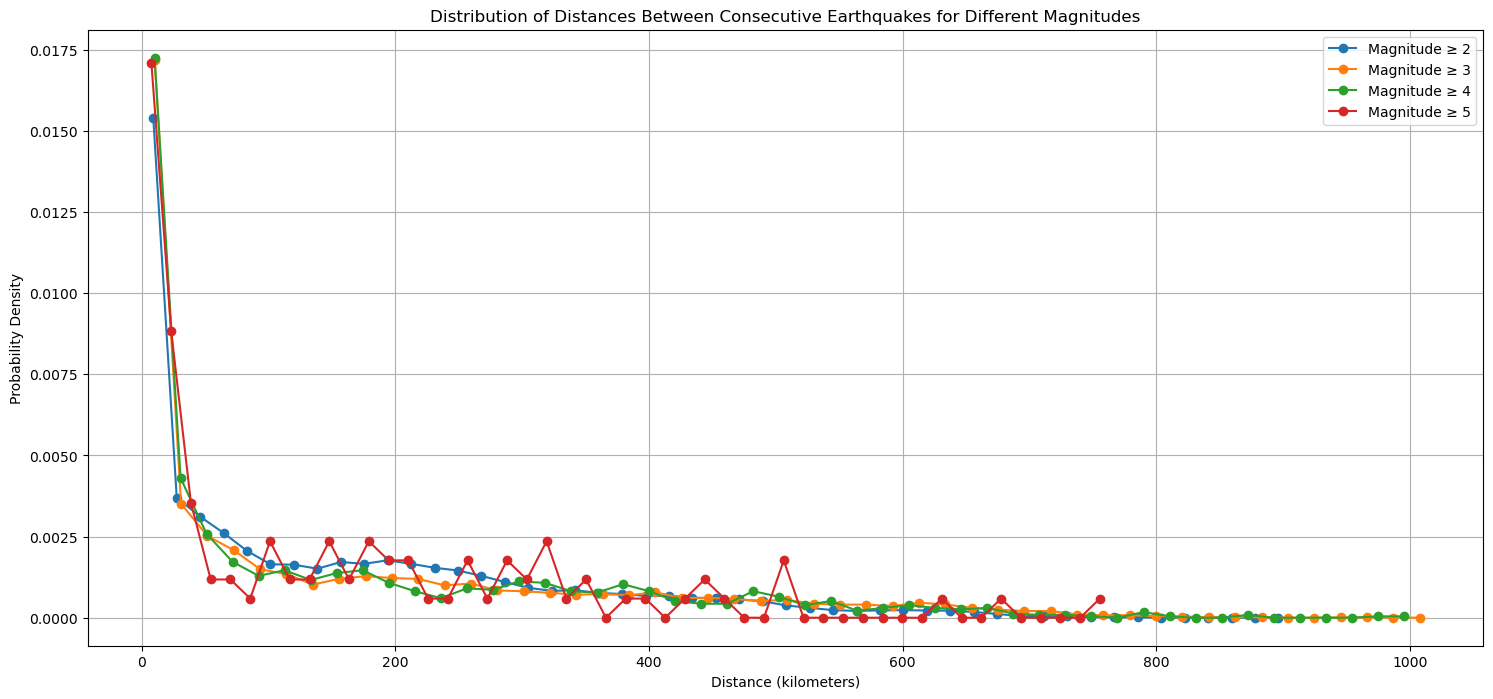

In [13]:
plt.figure(figsize=(18, 8))

for m, waiting_distances in waiting_distances_by_magnitude.items():
    bins = np.linspace(0, max(waiting_distances), 50)
    hist, bin_edges = np.histogram(waiting_distances, bins=bins, density=True)
    plt.plot((bin_edges[:-1] + bin_edges[1:]) / 2, hist, marker='o', linestyle='-', label=f'Magnitude ≥ {m}')

plt.title('Distribution of Distances Between Consecutive Earthquakes for Different Magnitudes')
plt.xlabel('Distance (kilometers)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()



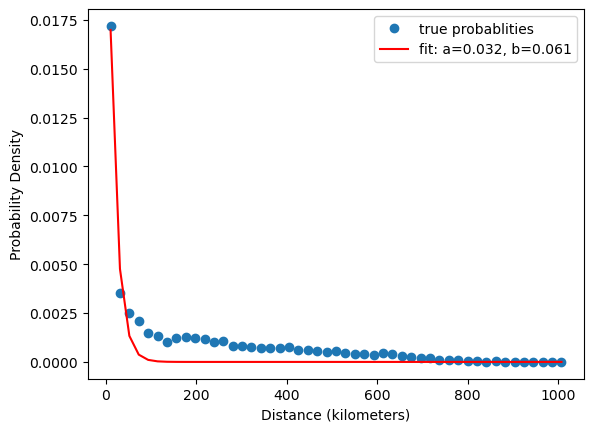

In [14]:
from scipy.optimize import curve_fit

def exponential_func(x, a, b):
    return a * np.exp(-b * x)

# Example fitting for one magnitude threshold
m = 3
distances = waiting_distances_by_magnitude[m]
bins = np.linspace(0, max(distances), 50)
hist, bin_edges = np.histogram(distances, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

popt, pcov = curve_fit(exponential_func, bin_centers, hist, p0=(1, 0.001))

# Plot the fitting result
plt.plot(bin_centers, hist, 'o', label='true probablities')
plt.plot(bin_centers, exponential_func(bin_centers, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Distance (kilometers)')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


In [15]:
def compute_filtered_waiting_times(data, magnitude_threshold, max_distance):
    # Filter data for the given magnitude threshold
    filtered_data = data[data['magnitude'] >= magnitude_threshold]
    filtered_data = filtered_data.sort_values(by='time')

    # Calculate distances and waiting times
    coordinates = filtered_data[['x', 'y', 'z']].values
    times = filtered_data['time'].values
    distances = np.sqrt(np.sum(np.diff(coordinates, axis=0)**2, axis=1))/1000
    waiting_times = np.diff(times)
    # print(min(distances),max(distances))

    # Filter by distance
    valid_indices = distances <= max_distance
    filtered_waiting_times = waiting_times[valid_indices]

    return filtered_waiting_times

# Parameters to analyze
magnitude_thresholds = [4, 5]
max_distances = [400,600]  # Example distance thresholds in kilometers

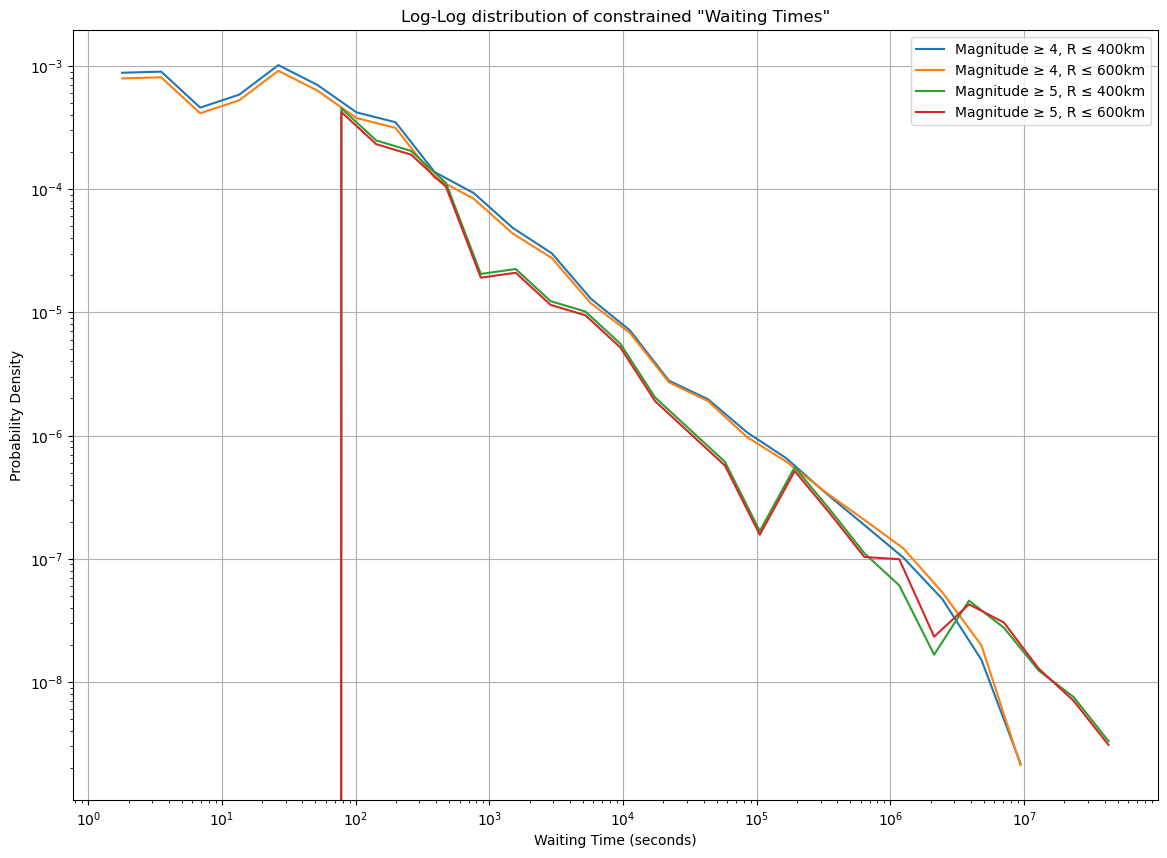

In [16]:
plt.figure(figsize=(14, 10))

for m in magnitude_thresholds:
    for R in max_distances:
        waiting_times = compute_filtered_waiting_times(data, m, R)
        if len(waiting_times) > 0:
            bins = np.logspace(np.log10(min(waiting_times)), np.log10(max(waiting_times)), num=25)
            hist, bin_edges = np.histogram(waiting_times, bins=bins, density=True)
            plt.loglog((bin_edges[:-1] + bin_edges[1:]) / 2, hist, label=f'Magnitude ≥ {m}, R ≤ {R}km')

plt.title('Log-Log distribution of constrained \"Waiting Times\"')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

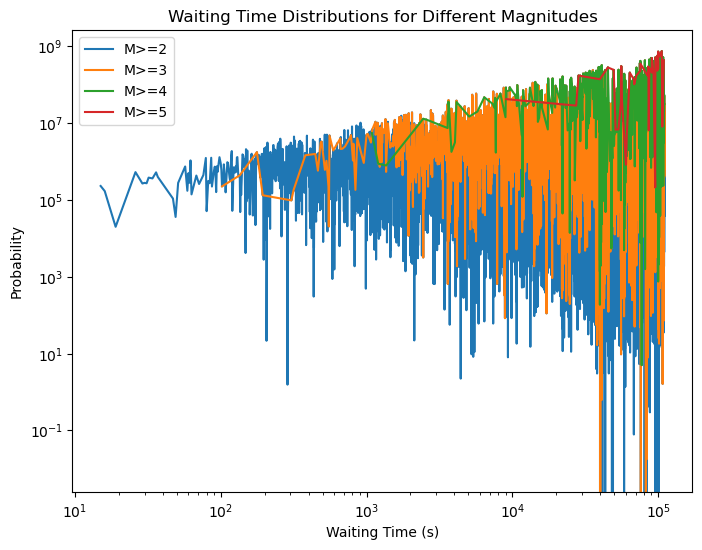

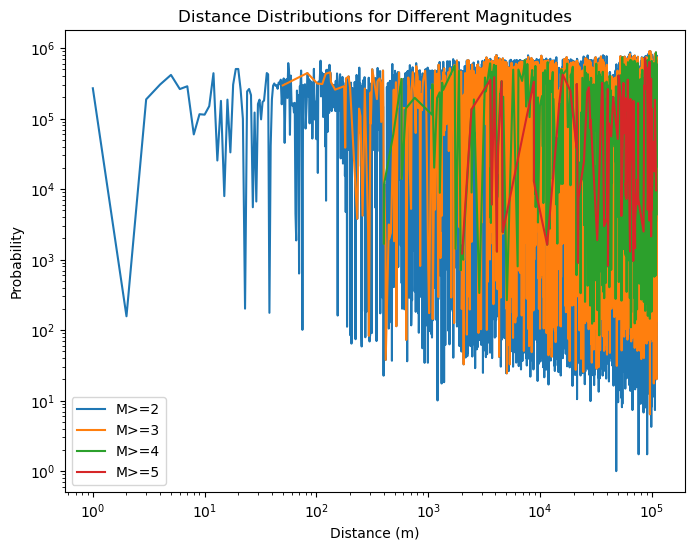

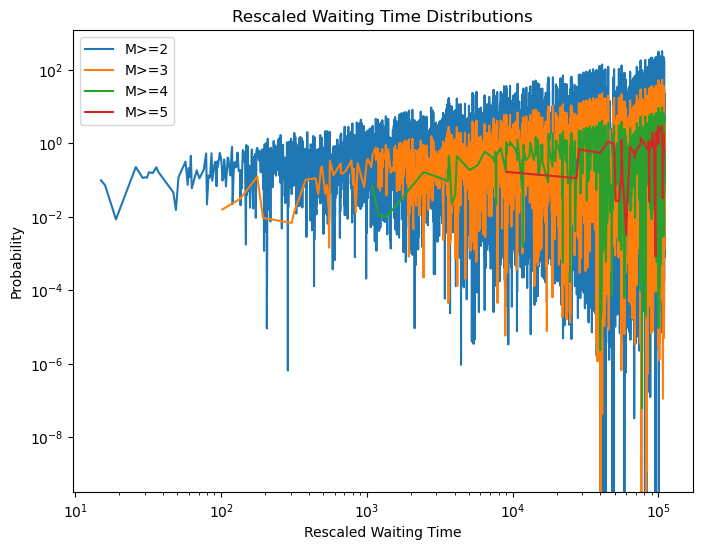

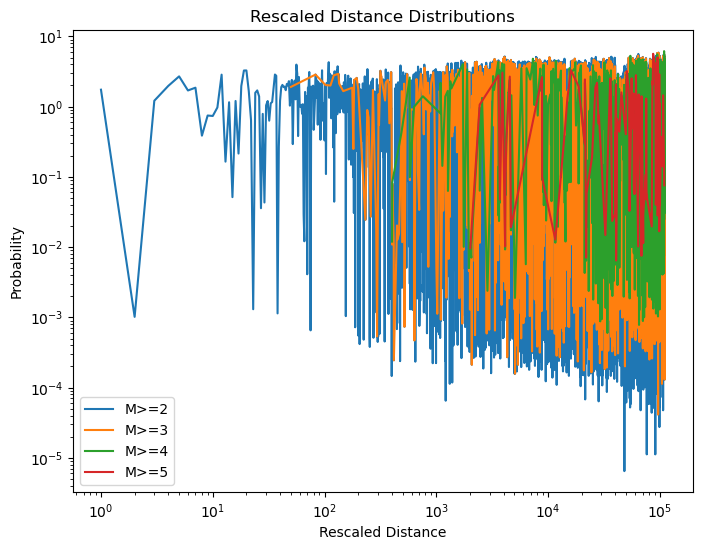

In [21]:
# Function to compute waiting times
# part 5
def compute_waiting_times(data, magnitude_threshold):
    # Filter data for the given magnitude threshold
    filtered_data = data[data['magnitude'] >= magnitude_threshold]
    filtered_data = filtered_data.sort_values(by='time')
    
    # Compute waiting times (time differences between consecutive earthquakes)
    waiting_times = np.diff(filtered_data['time'])
    return waiting_times

# Load the data
data_path = 'SouthCalifornia-1982-2011.dat'
columns = ['event_index', 'trigger_index', 'time', 'magnitude', 'x', 'y', 'z']
data = pd.read_csv(data_path, delim_whitespace=True, names=columns)

# Convert time from seconds to years for easier interpretation
data['time_years'] = data['time'] / (60 * 60 * 24 * 365.25)

# Analyze waiting time distributions for different magnitudes (m) and distances (R)
waiting_times = data.groupby(['magnitude'])['time'].diff().dropna()
waiting_time_dists = {}
for m in [2, 3, 4, 5]:
    waiting_time_dists[m] = waiting_times[data['magnitude'] >= m]

# Analyze distance distributions for different magnitudes 
distances = np.sqrt((data['x'].diff())**2 + (data['y'].diff())**2 + (data['z'].diff())**2)
distance_dists = {}
for m in [2, 3, 4, 5]:
    distance_dists[m] = distances[data['magnitude'] >= m]

# Analyze waiting times for events within distance R
waiting_time_dists_R = {}
for m in [2, 3, 4, 5]:
    for R in [10000, 20000, 50000]:
        mask = (data['magnitude'] >= m) & (distances <= R)
        waiting_time_dists_R[(m,R)] = data['time'].diff()[mask].dropna()

# Attempt to rescale distributions to a single curve
fig, ax = plt.subplots(figsize=(8,6))
for m, wt_dist in waiting_time_dists.items():
    ax.loglog(wt_dist, label=f'M>={m}')
ax.legend()
ax.set_xlabel('Waiting Time (s)')
ax.set_ylabel('Probability')
ax.set_title('Waiting Time Distributions for Different Magnitudes')

fig, ax = plt.subplots(figsize=(8,6))  
for m, d_dist in distance_dists.items():
    ax.loglog(d_dist, label=f'M>={m}')
ax.legend()
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Probability')
ax.set_title('Distance Distributions for Different Magnitudes')

plt.show()
fig, ax = plt.subplots(figsize=(8,6))
mean_waiting_times = {m: np.mean(wt_dist) for m, wt_dist in waiting_time_dists.items()}
for m, wt_dist in waiting_time_dists.items():
    scaled_wt_dist = wt_dist / mean_waiting_times[m]
    ax.loglog(scaled_wt_dist, label=f'M>={m}')
ax.legend()
ax.set_xlabel('Rescaled Waiting Time')
ax.set_ylabel('Probability')
ax.set_title('Rescaled Waiting Time Distributions')

fig, ax = plt.subplots(figsize=(8,6))
mean_distances = {m: np.mean(d_dist) for m, d_dist in distance_dists.items()}
for m, d_dist in distance_dists.items():
    scaled_d_dist = d_dist / mean_distances[m]
    ax.loglog(scaled_d_dist, label=f'M>={m}')
ax.legend()
ax.set_xlabel('Rescaled Distance')
ax.set_ylabel('Probability')
ax.set_title('Rescaled Distance Distributions')

plt.show()
